## Imports

In [27]:
import torch
from torch import nn, optim
import torchvision.transforms.functional as TF

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

import os
from os import listdir
from os.path import join
import cv2
import numpy as np

import matplotlib.pyplot as plt
from random import randint

png = './data/train/img/1803201916/img_00000000/1803201916-00000117.png'
if os.path.exists(png):
    _ = cv2.imread(png)
    cv2.imwrite(png[:-4]+'.jpg', _)
    os.remove(png)



## Visualization

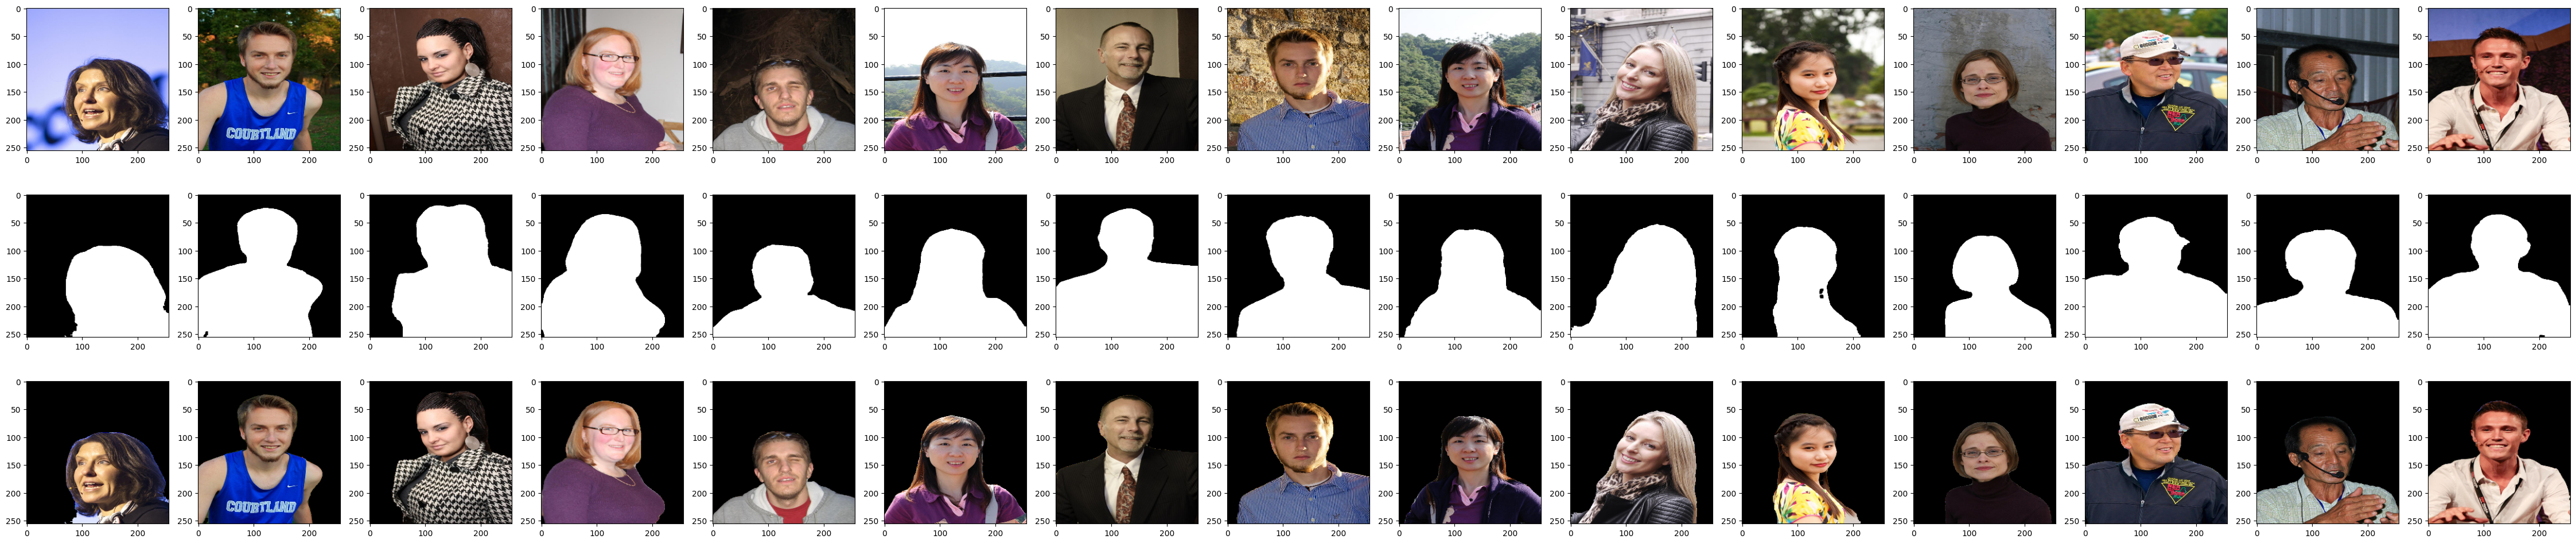

In [3]:
x_base = 'data/val/img/1803290444/img_00000000/'
y_base = x_base.replace('img', 'mask')

tokens = os.listdir(x_base)
num = min(15, len(tokens))

fig, axes = plt.subplots(3, num, figsize=(num*3, 10))

for i in range(num):
    idx = randint(0, len(tokens))
    img = cv2.cvtColor(cv2.imread(x_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) # w, h
    
    msk = cv2.cvtColor(cv2.imread(y_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    msk = cv2.resize(msk, (256, 256)) # w, h

    res = cv2.bitwise_and(img, msk)

    axes[0, i].imshow(img)
    axes[1, i].imshow(msk)
    axes[2, i].imshow(res)


plt.tight_layout()
plt.show()


## Dataset

In [8]:
class SegDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.images = []
        self.transform = transform

        for sub1 in listdir(join(base_dir, 'img')):
            for sub2 in listdir(join(base_dir, 'img', sub1)):
                for fn in listdir(join(base_dir, 'img', sub1, sub2)):
                    self.images.append(join(base_dir, 'img', sub1, sub2, fn))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.images[index].replace('img', 'mask'))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        return image / 255, mask / 255


## Utils

In [16]:
def load_checkpoint(checkpoint, model):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def get_loaders(
        train_dir,
        val_dir,
        batch_size,
        train_transform,
        val_transform,
        num_workers=2,
        pin_memory=True
):
    train_ds = SegDataset(
        base_dir=train_dir,
        transform=train_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
        drop_last=True,
    )

    val_ds = SegDataset(
        base_dir=val_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
        drop_last=True,
    )

    return train_loader, val_loader

def get_mean_std(loader):
    channels_sum, channels_squared_sum, n_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data.float(), dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data.float()**2, dim=[0, 2, 3])
        n_batches += 1

    mean = channels_sum / n_batches
    std = ((channels_squared_sum / n_batches) - mean**2) ** .5
    return mean, std

def model_eval(loader, model, device):
    n_correct = 0
    n_pixels = 0
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)

            # preds = torch.sigmoid(model(x))
            preds = torch.sigmoid(model(x)['out']) # if the model is deeplabv3
            preds = (preds > .5).float()

            n_correct += (preds == y).sum()
            n_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / ((preds+y).sum() + 1e-8)
    
    print(f'Accuracy: {(n_correct / n_pixels) * 100}, Dice-Score: {dice_score/len(loader)}')
    model.train()


## Train

In [37]:
# epochs 1.
LR = 1e-4
BATCH_SIZE = 20
NUM_WORKERS = 2 # >> nproc or lscpu
PIN_MEMORY = True
LOAD_MODEL = False
NUM_EPOCHS = 1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_IMAGE_DIR = './data/train/'
VAL_IMAGE_DIR = './data/val/'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for data, targets in loop:
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            # preds = model(data)
            preds = model(data)['out'] # if the model is deeplabv3
            loss = loss_fn(preds, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.5),
        A.Rotate(limit=45, p=.5),
        A.HorizontalFlip(p=.3),
        A.VerticalFlip(p=.2),
        A.RandomFog(fog_coef_lower=0.5, p=.2),
        A.RandomRain(p=.2),
        A.Sharpen(p=.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # the pretrianed model mean and std
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # model = UNet().to(DEVICE)

    # loading the pretrained deeplabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

    # adding a layer at the end
    model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_loader, val_loader = get_loaders(
        TRAIN_IMAGE_DIR,
        VAL_IMAGE_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load('checkpoint.pth.tar'), model)
    
    if torch.cuda.is_available():
        model.to('cuda')

    model.train()
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint)

        print('Epoch:', epoch, end=', ')
        model_eval(val_loader, model, DEVICE)

main()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 645/645 [04:09<00:00,  2.58it/s, loss=0.0681]


=> Saving checkpoint
Epoch: 0, Accuracy: 98.1558609008789, Dice-Score: 0.9887409210205078


## Testing Model Performance/Accuracy

In [99]:
# load model

# model = UNet()

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))

load_checkpoint(torch.load('checkpoint.pth.tar'), model)

model.eval()

aug = A.Compose([
    A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.3),
    A.Rotate(limit=45, p=.7),
    A.HorizontalFlip(p=.6),
    A.VerticalFlip(p=.5),
    A.RandomFog(fog_coef_lower=0.5, p=.15),
    A.RandomRain(p=.15),
    A.Sharpen(p=.2),
])

mean_vals = np.array([0.485, 0.456, 0.406])
std_vals = np.array([0.229, 0.224, 0.225])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    aug,
    A.Normalize(mean=mean_vals, std=std_vals),
    ToTensorV2()
])

val_ds = SegDataset(
    base_dir='./data/val/',
    transform=val_transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=10,
    num_workers=2,
    pin_memory=False,
    shuffle=False,
    drop_last=True
)

preds = []
X = []
Y = []

for x, y in tqdm(val_loader):
    with torch.no_grad():
        preds.append(model(x)['out'])
        X.append(x)
        Y.append(y)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


=> Loading checkpoint


100%|██████████| 16/16 [03:52<00:00, 14.53s/it]


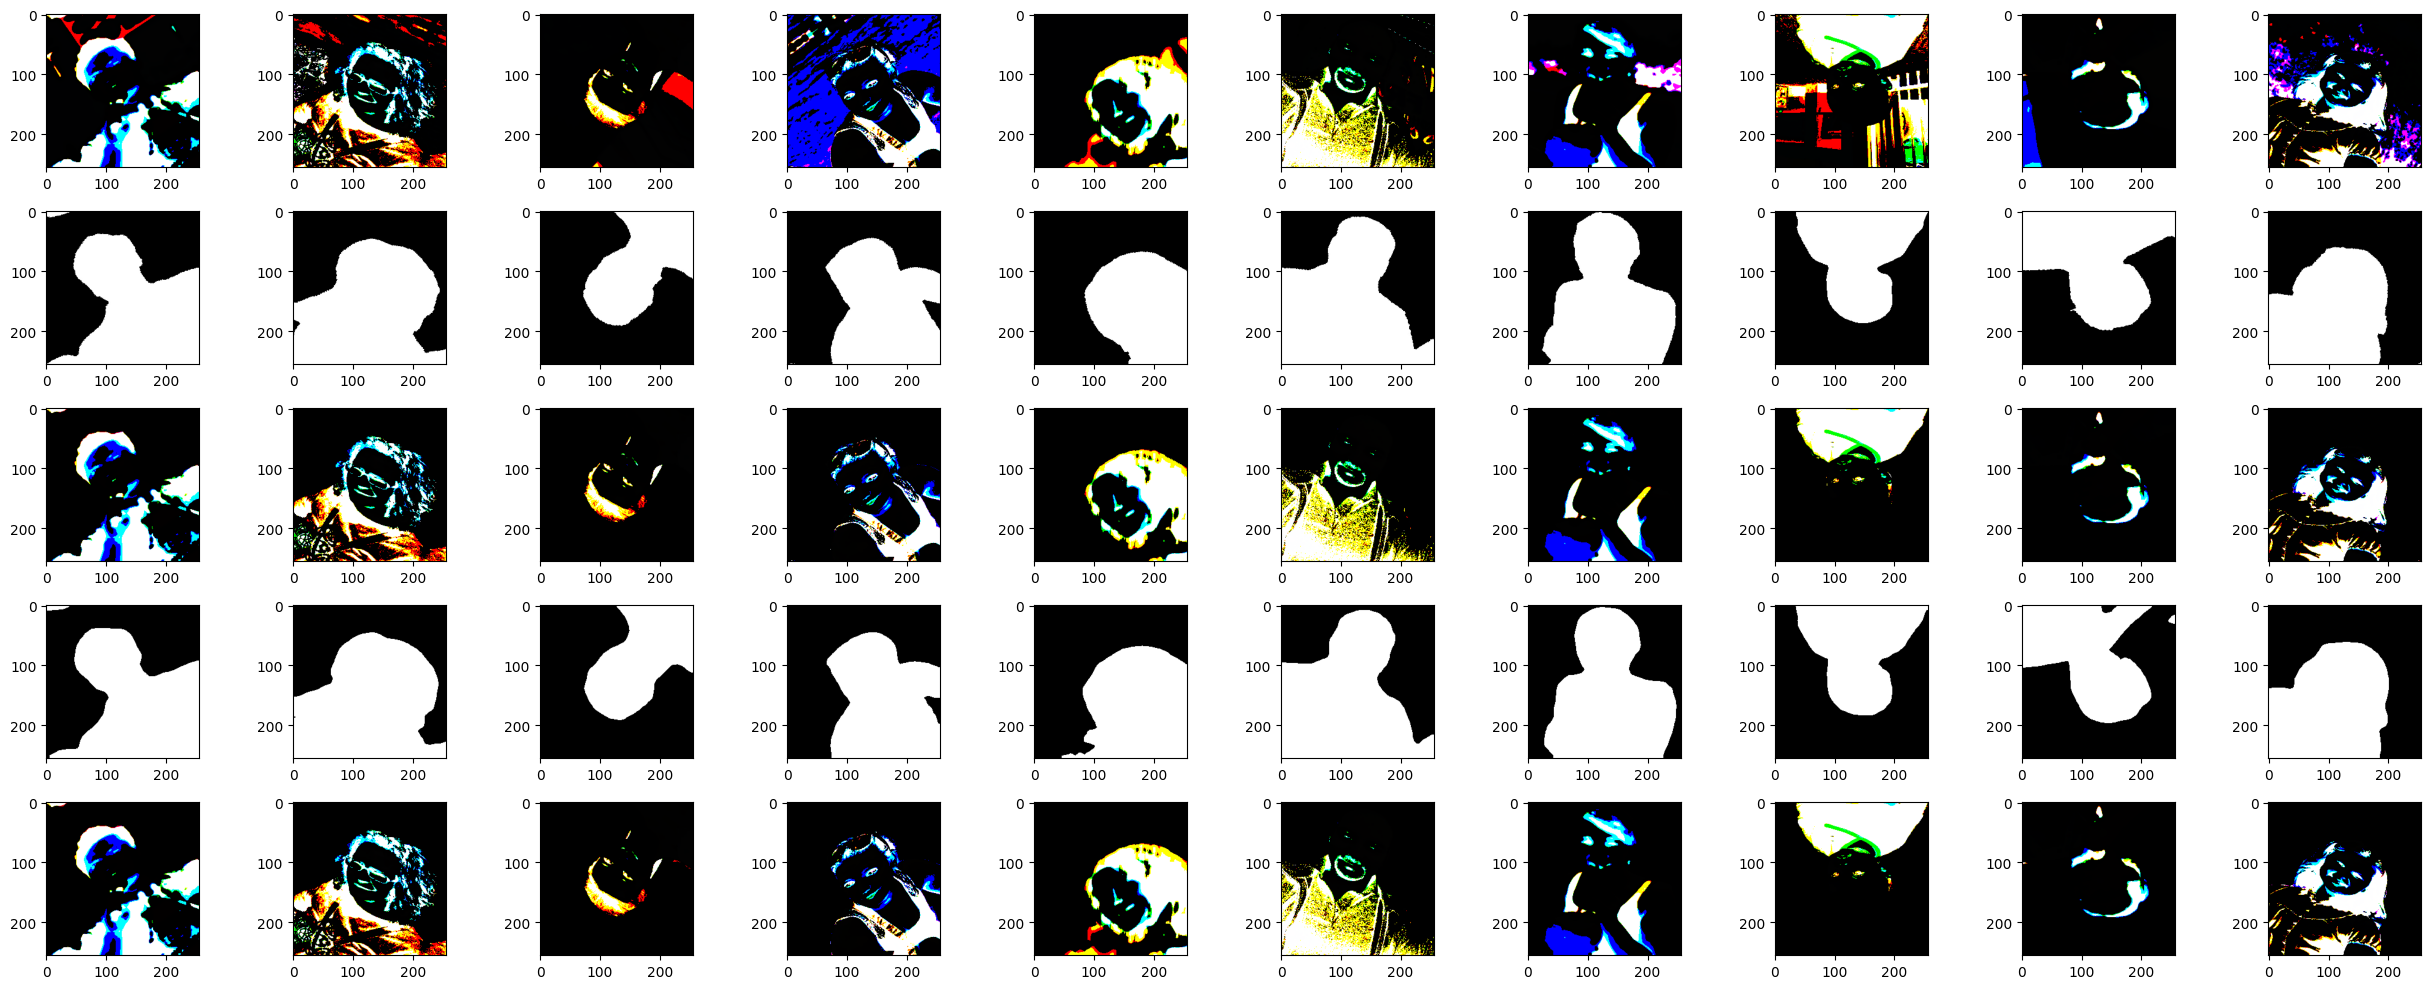

In [100]:
# from random import randint
# batch_idx = randint(0, len(X)-1)

batch_idx = 9 # max 15

fig, axes = plt.subplots(5, 10, figsize=(25, 10))

Img = X[batch_idx]
Mask = Y[batch_idx]
Pred = preds[batch_idx]

for idx, (img, mask, pred) in enumerate(zip(Img, Mask, Pred)):
    img = (np.transpose(img.numpy(), (1, 2, 0)) * 255).astype('uint8')
    mask = (cv2.cvtColor(mask.numpy(), cv2.COLOR_GRAY2RGB) * 255).astype('uint8')
    pred = (torch.sigmoid(pred.detach()) > .5).float().numpy().squeeze()
    pred = (cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB) * 255).astype('uint8')

    truth_res = cv2.bitwise_and(img, mask)
    pred_res = cv2.bitwise_and(img, pred)

    axes[0, idx].imshow(img)
    axes[1, idx].imshow(mask)
    axes[2, idx].imshow(truth_res)
    axes[3, idx].imshow(pred)
    axes[4, idx].imshow(pred_res)

plt.tight_layout()
plt.show()


## Saving the model

In [101]:
# !ls -Flash

# model = UNet()
# load_checkpoint(torch.load('checkpoint.pth.tar'), model)
# torch.save(model, 'unet_bg_seg_model_v2.pth')

# !zip unet_bg_seg_model_v2.pth.zip unet_bg_seg_model_v2.pth

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))

load_checkpoint(torch.load('checkpoint.pth.tar'), model)

torch.save(model, 'deeplabv3_bg_seg_model.pth')
!zip deeplabv3_bg_seg_model.pth.zip deeplabv3_bg_seg_model.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading checkpoint
  adding: deeplabv3_bg_seg_model.pth (deflated 7%)


### Experimentaing on different Augmentations

In [ ]:
val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.3),
    A.Rotate(limit=45, p=.7),
    A.HorizontalFlip(p=.6),
    A.VerticalFlip(p=.5),
    A.RandomFog(fog_coef_lower=0.5, p=.15),
    A.RandomRain(p=.15),
    A.Sharpen(p=.2),
    ToTensorV2()
])

val_ds = SegDataset(
    base_dir='./data/val/',
    transform=val_transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=10,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
    drop_last=True
)

for x, y in val_loader:
    break

fig, axes = plt.subplots(3, 10, figsize=(20, 5))

for idx, (img, mask) in enumerate(zip(x, y)):
    img = (np.transpose(img.numpy(), (1, 2, 0)) * 255).astype('uint8')
    mask = (cv2.cvtColor(mask.numpy(), cv2.COLOR_GRAY2RGB) * 255).astype('uint8')

    res = cv2.bitwise_and(img, mask)

    axes[0, idx].imshow(img)
    axes[1, idx].imshow(mask)
    axes[2, idx].imshow(res)

plt.tight_layout()
plt.show()
